In [2]:
import numpy as np
import scipy as sp
import os
import math
import time
import pickle as pkl
import matplotlib.pyplot as plt
#% matplotlib inline


dir_results = '../results'
dir_base = '../figures'
dir_date = 'jun1_2020'

# Evaluating data from RD_script.py

In [3]:
'''
echo 'Continuas data, Normal, Normal model'
'exp_06-28-2020_17-18-38.p'; dir_type = 'synth_cont' # OLS_poly1
'exp_06-28-2020_17-21-05.p'; dir_type = 'synth_cont' # OLS_poly2
'exp_06-28-2020_17-23-30.p'; dir_type = 'synth_cont' # OLS_poly4

echo 'Binary data, Normal, Normal model'
'exp_06-28-2020_17-14-18.p'; dir_type = 'synth_binary' # OLS_poly1
'exp_06-28-2020_17-15-44.p'; dir_type = 'synth_binary' # OLS_poly2
'exp_06-28-2020_17-17-11.p'; dir_type = 'synth_binary' # OLS_poly4

echo 'Binary data, Logit, Bernoulli model'
'exp_06-28-2020_15-46-56.p'; dir_type = 'synth_binary' # Logit_poly1
'exp_06-28-2020_16-18-54.p'; dir_type = 'synth_binary' # Logit_poly2
'exp_06-28-2020_16-50-26.p'; dir_type = 'synth_binary' # Logit_poly4
'''

file_results = 'exp_06-28-2020_17-18-38.p'; dir_type = 'synth_cont' # OLS_poly1
tosave =  False #  True # 


## Plot NIG, estimated \tau, and placebos

Obs model: normal
Data type: cont
f_base: OLS_poly1
variable: z_eff
k: 50
top_subsets: 1
poly_xT: 1


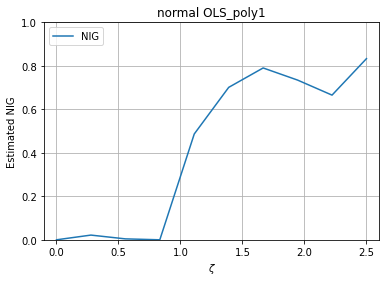

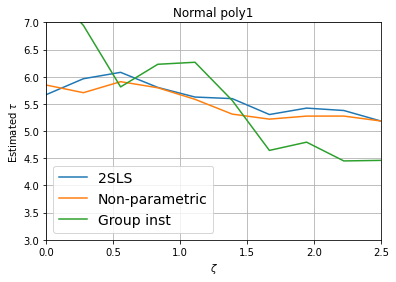

<ipython-input-4-563797caeffb>:89: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(lines, ['x-indiv',  'x-multi', 'y-indiv','y-multi'], loc=2)


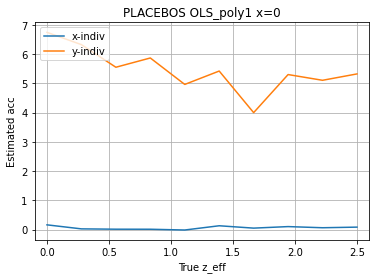

<ipython-input-4-563797caeffb>:89: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(lines, ['x-indiv',  'x-multi', 'y-indiv','y-multi'], loc=2)


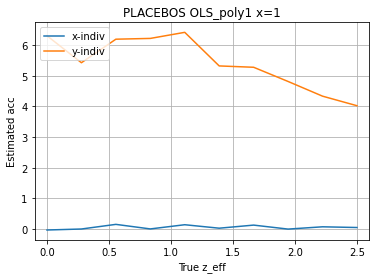

In [4]:
# Load data
[data_save, args] = pkl.load(open( os.path.join(dir_results,file_results), "rb" ) )
dir_save = os.path.join(dir_base, dir_type, dir_date)

# Print the key parameters of the data for the user to see for any debugging
print ('Obs model:',args.obs_model)
print ('Data type:',args.data_type)
print ('f_base:',args.f_base)
print ('variable:',args.variable)
print ('k:',args.k)
print ('top_subsets:',args.top_subsets)
try: print ('poly_xT:', args.poly_xT)
except: a=1

# Store the data in variables for ease of use
z_effs = data_save['z_effs']
T_effs = data_save['T_effs']
T_bses = data_save['T_bses']
placebos = data_save['T_placebos']
accs = data_save['accs']
values_vary = args.linspace
if args.variable == 'fuzzy':
    values_vary = args.linspace
    
# Remove error values
T_effs[abs(T_effs)==np.inf] = np.nan
T_effs[abs(T_effs) > 1e10] = np.nan

dot = 'spot' # 'range' #

# Plot NIG
lines = [0]*2#accs.shape[2]
fig = plt.figure()
for aa_ii, aa in enumerate([2]):
    if dot=='range': lines[aa_ii] = plt.errorbar(values_vary, np.nanmean(accs[:,:,aa],axis=0), yerr=np.nanstd(accs[:,:,aa],axis=0), fmt='o', label='Line '+str(aa))
    elif dot=='spot': lines[aa_ii], = plt.plot(values_vary, np.nanmean(accs[:,:,aa],axis=0), label='Line '+str(aa))
    
    plt.xlabel('$\zeta$')
    plt.ylabel('Estimated NIG')
    plt.grid()
    plt.xlim([min(values_vary)-0.1, max(values_vary)+0.1])
    plt.ylim([0.0,1.0])
plt.title(args.obs_model + ' ' + args.f_base)
plt.grid(True)
plt.legend(lines, ['NIG'], loc=2)
plt.show()
if tosave:
    fig.savefig(os.path.join(dir_save,"acc_"+args.data_type+"_"+args.obs_model+"_"+args.f_base+"_k"+str(args.k)+".png"))

# Plot estimated \tau
lines = [0]*4 # T_effs.shape[2]
fig = plt.figure()
for aa in range(3):
    if dot=='range': lines[aa] = plt.errorbar(values_vary, np.nanmean(T_effs[:,:,aa],axis=0), yerr=np.nanstd(T_effs[:,:,aa],axis=0), fmt='o', label='Line '+str(aa))
    elif dot=='spot': lines[aa], = plt.plot(values_vary, np.nanmean(T_effs[:,:,aa],axis=0), label='Line '+str(aa))
    if dir_type=='synth_cont': plt.xlabel('$\zeta$')
    elif dir_type=='synth_binary': plt.xlabel('$\zeta$')
    plt.ylabel('Estimated ' + '$\\tau$')
    plt.grid()
    plt.xlim([min(values_vary)-0.0, max(values_vary)+0.0])
    if dir_type=='synth_cont':   plt.ylim([3, 7])  # synth
    elif dir_type=='synth_binary': plt.ylim([3, 7])  # synth
plt.title(args.obs_model.capitalize() + ' ' + args.f_base.split('_')[1])
plt.grid(True)
plt.legend(lines, ['2SLS', 'Non-parametric','Group inst'], loc=3, fontsize=14)    
plt.show()
if tosave:
    fig.savefig(os.path.join(dir_save,"Teff1_"+args.data_type+"_"+args.obs_model+"_"+args.f_base+"_k"+str(args.k)+".png"))

# Placebo testing results
lines = [0]*2*2
for xi in range(placebos.shape[3]):
    fig = plt.figure()
    for aa,ll in enumerate(range(0,4,2)): #indiv/multi
        
        if dot=='range': 
            lines[ll] = plt.errorbar(values_vary, np.nanmean(placebos[:,:,0,xi,aa],axis=0), yerr=np.nanstd(placebos[:,:,0,xi,aa],axis=0), fmt='o', label='Line '+str(aa))
            #lines[ll+1] = plt.errorbar(values_vary, np.nanmean(placebos[:,:,1,xi,aa],axis=0), yerr=np.nanstd(placebos[:,:,1,xi,aa],axis=0), fmt='o', label='Line '+str(aa))
        elif dot=='spot':
            lines[ll], = plt.plot(values_vary, np.nanmean(placebos[:,:,0,xi,aa],axis=0), label='Line '+str(aa))            
            #lines[ll+1], = plt.plot(values_vary, np.nanmean(placebos[:,:,1,xi,aa],axis=0), label='Line '+str(aa))            
            
    plt.xlabel('True '+args.variable)
    plt.ylabel('Estimated acc')
    plt.grid()
    plt.xlim([min(values_vary)-0.1, max(values_vary)+0.1])
    plt.title('PLACEBOS ' + str(args.f_base) + ' x=' + str(xi))
    plt.grid(True)
    plt.legend(lines, ['x-indiv',  'x-multi', 'y-indiv','y-multi'], loc=2)
    #plt.ylim([-0.1, 7])
    plt.show()
    if tosave:
        fig.savefig(os.path.join(dir_save,"placebo"+str(xi)+"_"+args.data_type+"_"+args.f_base+"_k"+str(args.k)+".png"))

## Multiple results collated for NIG

#### User input

In [7]:
# Files to be combined into a single graph
files_results = ['exp_06-28-2020_17-18-38.p','exp_06-28-2020_17-21-05.p','exp_06-28-2020_17-23-30.p']
dir_type = 'synth_cont'
# Plot string
title='Normal observation model on $T\in R$'; 
legend_strs = ['poly1','poly2','poly4']

#### Run code for plots

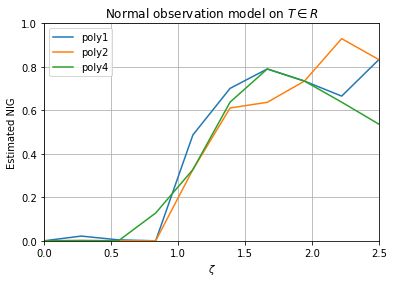

In [8]:
fig = plt.figure()
lines = [0]*len(files_results)
aa = 2 # pick out NIG avg

for aa_ii, file_results in enumerate(files_results):
    
    # LOAD DATA
    [data_save, args] = pkl.load(open( os.path.join(dir_results,file_results), "rb" ) )
    z_effs = data_save['z_effs']
    T_effs = data_save['T_effs']
    T_bses = data_save['T_bses']
    accs = data_save['accs']
    values_vary = args.linspace
    T_effs[abs(T_effs)==np.inf] = np.nan

    if args.variable == 'fuzzy':
        values_vary = args.linspace
    
    # PLOT DATA
    if dot=='range': lines[aa_ii] = plt.errorbar(values_vary, np.nanmean(accs[:,:,aa],axis=0), yerr=np.nanstd(accs[:,:,aa],axis=0), fmt='o', label='Line '+str(aa))
    elif dot=='spot': lines[aa_ii], = plt.plot(values_vary, np.nanmean(accs[:,:,aa],axis=0), label='Line '+str(aa))
    if dir_type=='synth_cont': plt.xlabel('$\zeta$')
    elif dir_type=='synth_binary': plt.xlabel('$\zeta$')
    elif dir_type=='synth_px': plt.xlabel('Dimensions in x')
    elif dir_type=='synth_pz': plt.xlabel('Dimensions in z')
    else: assert(False, 'No proper dir_type specified')
    plt.ylabel('Estimated NIG')
    plt.grid()
    if (dir_type=='synth_px')|(dir_type=='synth_pz')|(dir_type=='synth_cont')|(dir_type=='synth_binary'): 
        plt.xlim([min(values_vary)-0., max(values_vary)+0.0])
    else: 
        plt.xlim(0.5, 1)
    
    plt.ylim([0.0,1.0])

plt.title(title)
plt.grid(True)
plt.legend(lines, legend_strs, loc=2)  
    
plt.show()
if tosave:
    dir_save = os.path.join(dir_base, dir_type, dir_date)
    fig.savefig(os.path.join(dir_save,"acc_"+args.data_type+"_"+args.obs_model+"_"+'ALL'+"_k"+str(args.k)+".png"))